# Importing necessary libraries

In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from IPython.display import Image, display

In [2]:
IMAGE_SIZE = (256,256)

# Preprocessing

In [5]:
def histogram_equalization(img_in):
    # segregate color streams
    b, g, r = cv2.split(img_in)
    h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
    h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
    h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
    # calculate cdf
    cdf_b = np.cumsum(h_b)
    cdf_g = np.cumsum(h_g)
    cdf_r = np.cumsum(h_r)

    # mask all pixels with value=0 and replace it with mean of the pixel values
    cdf_m_b = np.ma.masked_equal(cdf_b, 0)
    cdf_m_b = (cdf_m_b - cdf_m_b.min()) * 255 / (cdf_m_b.max() - cdf_m_b.min())
    cdf_final_b = np.ma.filled(cdf_m_b, 0).astype('uint8')

    cdf_m_g = np.ma.masked_equal(cdf_g, 0)
    cdf_m_g = (cdf_m_g - cdf_m_g.min()) * 255 / (cdf_m_g.max() - cdf_m_g.min())
    cdf_final_g = np.ma.filled(cdf_m_g, 0).astype('uint8')


    cdf_m_r = np.ma.masked_equal(cdf_r, 0)
    cdf_m_r = (cdf_m_r - cdf_m_r.min()) * 255 / (cdf_m_r.max() - cdf_m_r.min())
    cdf_final_r = np.ma.filled(cdf_m_r, 0).astype('uint8')
    # merge the images in the three channels
    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]

    img_out = cv2.merge((img_b, img_g, img_r))
    # validation
    equ_b = cv2.equalizeHist(b)
    equ_g = cv2.equalizeHist(g)
    equ_r = cv2.equalizeHist(r)
    equ = cv2.merge((equ_b, equ_g, equ_r))
    # print(equ)
    # cv2.imwrite('output_name.png', equ)
    return img_out



In [6]:
def preprocess_image(img_path):
    image = cv2.imread(img_path)
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = histogram_equalization(original_image)
    image = cv2.resize(image, IMAGE_SIZE) 
    return image

# Defining Classes

These are the following five classes predicted by the model
1. Crack_images
2. Footpath_images
3. Manholes_images
4. No-Crack_images
5. Road-Partition_images

In [7]:
class_names = ['crack-augmented', 'foot-path-augmented', 'man-holes-augmented', 'no-crack-images','road-partition-augmented']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}


nb_classes = len(class_names)

In [8]:
class_names_label

{'crack-augmented': 0,
 'foot-path-augmented': 1,
 'man-holes-augmented': 2,
 'no-crack-images': 3,
 'road-partition-augmented': 4}

# Loading Dataset after preprocessing

In [79]:
def load_data(path):
    
    dataset = path
    output = []
    for i in range(0,1):
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = preprocess_image(img_path)
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [10]:
(train_images, train_labels) = load_data('/kaggle/input/crack-images-thermal')[0]

Loading /kaggle/input/crack-images-thermal


100%|██████████| 731/731 [01:39<00:00,  7.38it/s]


In [12]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Dataset Exploration

In [13]:
n_train = train_labels.shape[0]
# n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
# print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 2885
Each image is of size: (256, 256)


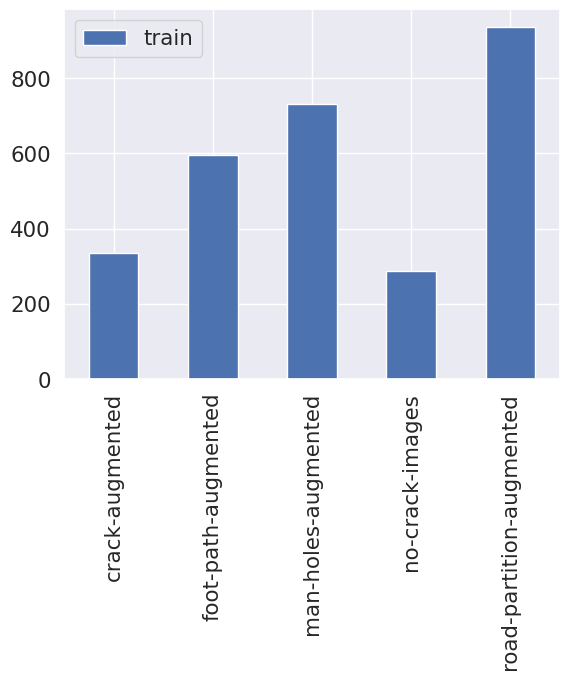

In [14]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
# _, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

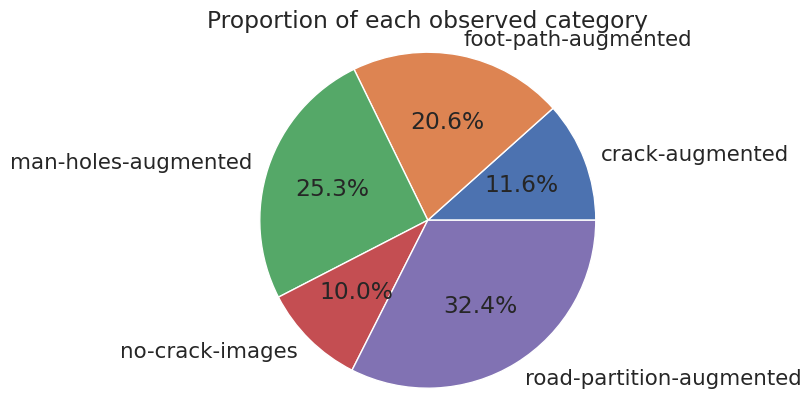

In [15]:
plt.pie(train_counts,
        explode=(0, 0, 0,0,0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [16]:
train_images = train_images / 255.0 
# test_images = test_images / 255.0

In [17]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

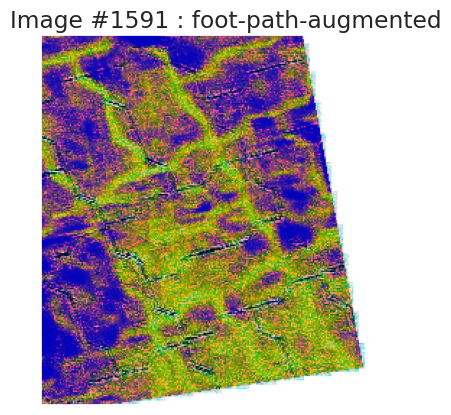

In [19]:
display_random_image(class_names, train_images, train_labels)

In [22]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i],cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

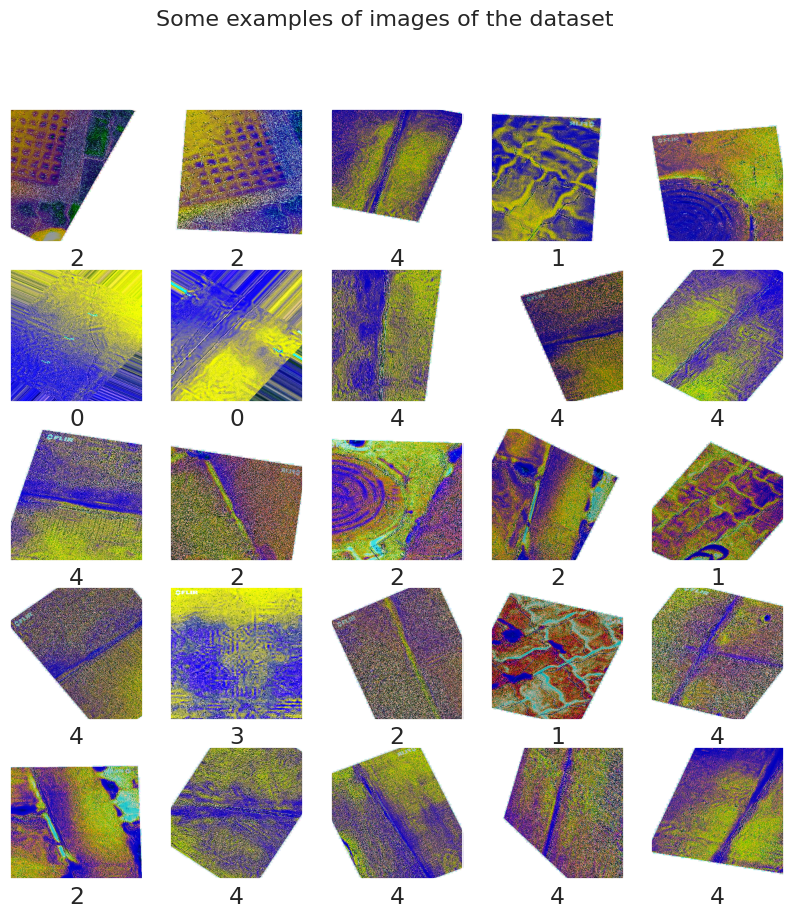

In [23]:
display_examples(class_names, train_images, train_labels)

In [24]:
train_labels

array([2, 2, 4, ..., 2, 4, 0], dtype=int32)

In [26]:
from tensorflow.keras.utils import to_categorical

train_labels_one_hot = to_categorical(train_labels)

In [27]:
train_labels_one_hot

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (256,256, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [38]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
19/19 [==============================] - 6s 232ms/step - loss: 0.4301 - accuracy: 0.8657 - val_loss: 0.5843 - val_accuracy: 0.7712
Epoch 2/10
19/19 [==============================] - 3s 165ms/step - loss: 0.1122 - accuracy: 0.9766 - val_loss: 0.6199 - val_accuracy: 0.8076
Epoch 3/10
19/19 [==============================] - 3s 168ms/step - loss: 0.0546 - accuracy: 0.9922 - val_loss: 0.6519 - val_accuracy: 0.7834
Epoch 4/10
19/19 [==============================] - 3s 166ms/step - loss: 0.0774 - accuracy: 0.9788 - val_loss: 0.7524 - val_accuracy: 0.7348
Epoch 5/10
19/19 [==============================] - 3s 166ms/step - loss: 0.0368 - accuracy: 0.9948 - val_loss: 0.6730 - val_accuracy: 0.7920
Epoch 6/10
19/19 [==============================] - 3s 168ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.6306 - val_accuracy: 0.8111
Epoch 7/10
19/19 [==============================] - 3s 167ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.6951 - val_accuracy: 0.8007
Epoch 

In [41]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

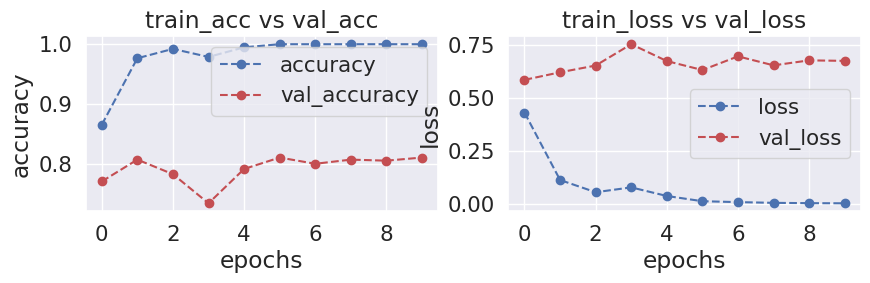

In [42]:
plot_accuracy_loss(history)


In [31]:
class_names = ['crack-augmented', 'foot-path-augmented', 'man-holes-augmented', 'no-crack-images','road-partition-augmented']

In [64]:
def predict_image(img_path,true_class_name):
    img_path = img_path
    image = preprocess_image(img_path)
    test_image = []
    test_image.append(image);
    test_image = np.array(test_image)
    plt.imshow(image)

    # Make predictions
    predictions = model.predict(test_image)
    print("Predictions:")
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]
    print(f"the predicted_class is:{predicted_class_name}")
    print(f"the true_class is:{true_class_name}")

1/1 [==============================] - 0s 24ms/step
Predictions:
the predicted_class is:crack-augmented
the true_class is:crack_augmented


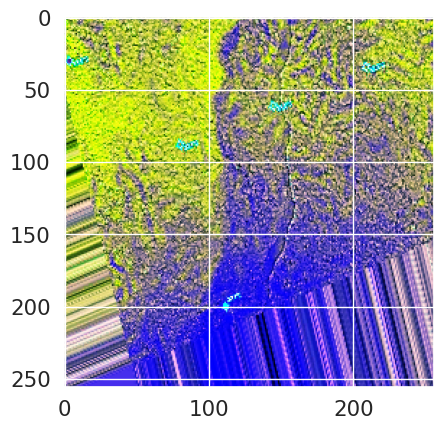

In [65]:

# Load and preprocess the image
# img_path = "/kaggle/input/cracks-classification/foot-path-augmented/FLIR_0_1364.jpg"
img_path = "/kaggle/input/test-crack-images/crack-augmented/aug_0_1045.jpeg"
predict_image(img_path, 'crack_augmented')

1/1 [==============================] - 0s 20ms/step
Predictions:
the predicted_class is:foot-path-augmented
the true_class is:foot_path_augmented


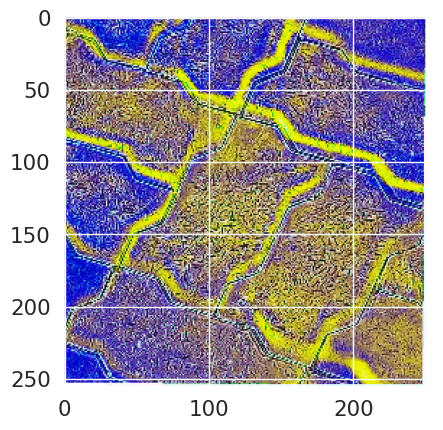

In [66]:
# Load and preprocess the image
img_path = "/kaggle/input/test-crack-images/foot-path-augmented/FLIR_0_1083.jpg"
predict_image(img_path,'foot_path_augmented')

1/1 [==============================] - 0s 20ms/step
Predictions:
the predicted_class is:man-holes-augmented


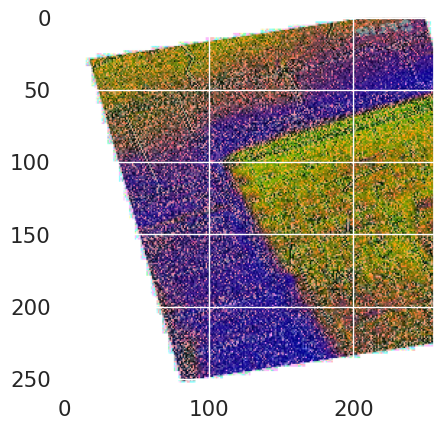

In [58]:

# Load and preprocess the image
# img_path = "/kaggle/input/cracks-classification/foot-path-augmented/FLIR_0_1364.jpg"
img_path = "/kaggle/input/crack-images-thermal/man-holes-augmented/FLIR_0_1139.jpg"
predict_image(img_path,'manholes-augmented')

1/1 [==============================] - 0s 21ms/step
Predictions:
the predicted_class is:no-crack-images


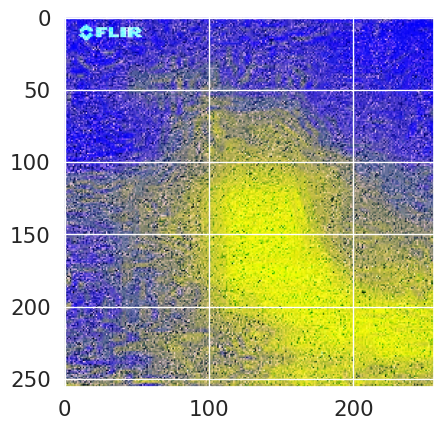

In [59]:

# Load and preprocess the image
# img_path = "/kaggle/input/cracks-classification/foot-path-augmented/FLIR_0_1364.jpg"
img_path = "/kaggle/input/crack-images-thermal/no-crack-images/1700313211997.jpg"
predict_image(img_path,'no-crack-images')

1/1 [==============================] - 0s 21ms/step
Predictions:
the predicted_class is:road-partition-augmented


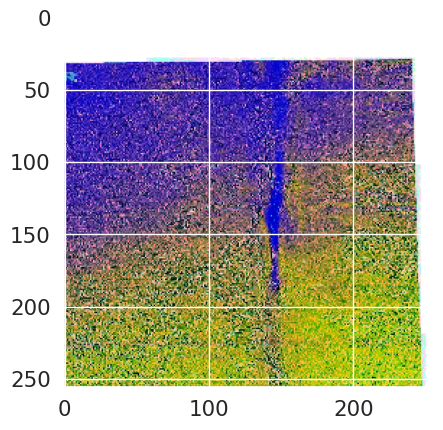

In [60]:

# Load and preprocess the image
# img_path = "/kaggle/input/cracks-classification/foot-path-augmented/FLIR_0_1364.jpg"
img_path = "/kaggle/input/crack-images-thermal/road-partition-augmented/FLIR_0_1087.jpg"
predict_image(img_path)

In [80]:
(test_images,test_labels) = load_data('/kaggle/input/test-crack-images')[0]

Loading /kaggle/input/test-crack-images


100%|██████████| 59/59 [00:07<00:00,  7.49it/s]


In [81]:
test_images = test_images / 255.0

In [98]:
predictions = model.predict(test_images)

9/9 [==============================] - 0s 18ms/step


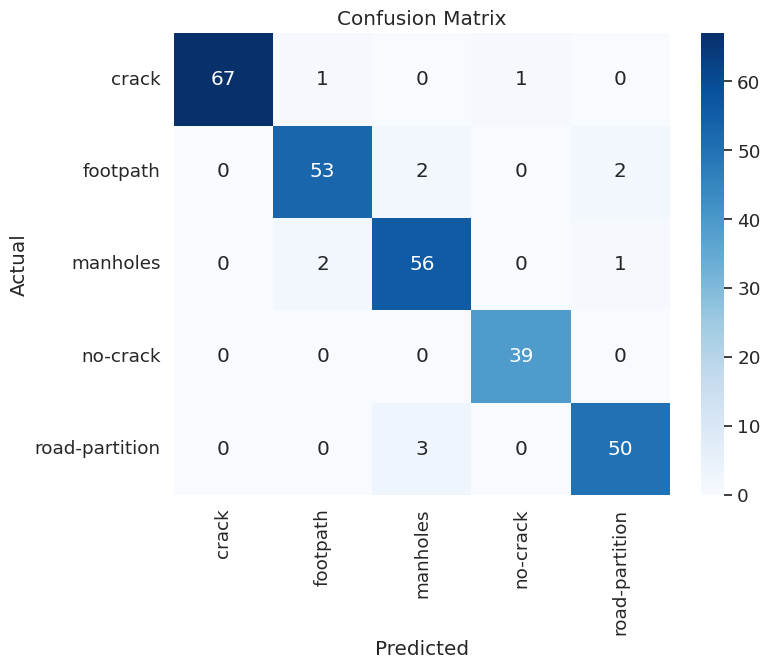

In [105]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
predicted_labels = predictions.argmax(axis=1)
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['crack', 'footpath', 'manholes','no-crack', 'road-partition'],
            yticklabels=['crack', 'footpath', 'manholes','no-crack', 'road-partition'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [106]:
classification_rep = classification_report(test_labels, predicted_labels)

In [107]:
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        69
           1       0.95      0.93      0.94        57
           2       0.92      0.95      0.93        59
           3       0.97      1.00      0.99        39
           4       0.94      0.94      0.94        53

    accuracy                           0.96       277
   macro avg       0.96      0.96      0.96       277
weighted avg       0.96      0.96      0.96       277

